# Modelos autorregresivos y autocorrelación parcial

## Introducción:

* En las clases anteriores introdujimos los conceptos de autocorrelación y correlación cruzada para analizar la relación entre una serie o series y sus versiones "laggeadas".

* Exploramos además cómo realizar regresiones lineales (con o sin lags) para explicar el comportamiento de una serie. Sirve para explicar tendencias, estacionalidad.

* Generalmente esto es *insuficiente* para explicar el comportamiento de una serie con dinámica interna.

* En general esto lo vimos como que "quedaba correlación" luego de los ajustes.

## Objetivos:

* Introducir la correlación como parte intrínseca de la serie. Hacer que los valores anteriores del proceso influyan directamente en el valor observado actual (autorregresivo, AR), y que valores anteriores del ruido influyan en el valor actual observado (media móvil, MA).

* Combinaciones de los dos anteriores da lugar a los modelos ARMA.

* Veremos cómo es posible:

  * Usar modelos ARMA para predecir valores futuros de una serie.
  * Ajustar los parámetros de un modelo ARMA a partir de observaciones.
  
* Si agregamos el caso no estacionario, veremos como *diferenciar* una serie puede producir estacionariedad. Esto da lugar a los modelos ARIMA (I=integrated).

## Definición:

Una *serie temporal* es una sucesión de variables aleatorias o *proceso estocástico* $x_0,x_1,x_2,\ldots$. La variable aleatoria $x_t$ denota el valor del proceso al tiempo $t$.

* Al proceso estocástico o serie temporal se lo denota por $\{x_t\}$.

* Típicamente (y para todo este curso) se consideran indexados por $t$ entero ($\ldots, -2, -1, 0, 1, 2, \ldots$).

* A los valores particulares que toma una serie temporal cuando la observamos se le denomina *realización* del proceso, y lo denotaremos por $x_t$, abusando un poco de la notación.

### Ruido blanco

__Definición:__ El caso más sencillo de serie temporal es un conjunto de variables aleatorias con la misma distribución y no correlacionadas. Si ${w_t}$ es una serie temporal en la cual las variables tienen media $E[w_t]=0$, varianza $Var(w_t) = \sigma_w^2 >0$ y la covarianza de $w_t$ y $w_s$ es $0$ se le denomina *ruido blanco*.  

__Definición:__ Si además las variables son independientes y con la misma distribución (iid), se le denomina ruido blanco independiente.

__Definición:__ En el caso que además la distribución de $w_t$ para cada $t$ sea Normal $N(0,\sigma_w^2)$ le llamamos *ruido blanco gaussiano*.

In [1]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata
#Importo astsadata
import warnings
with warnings.catch_warnings(action="ignore"):
    import astsadata as astsa
    
## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd

plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

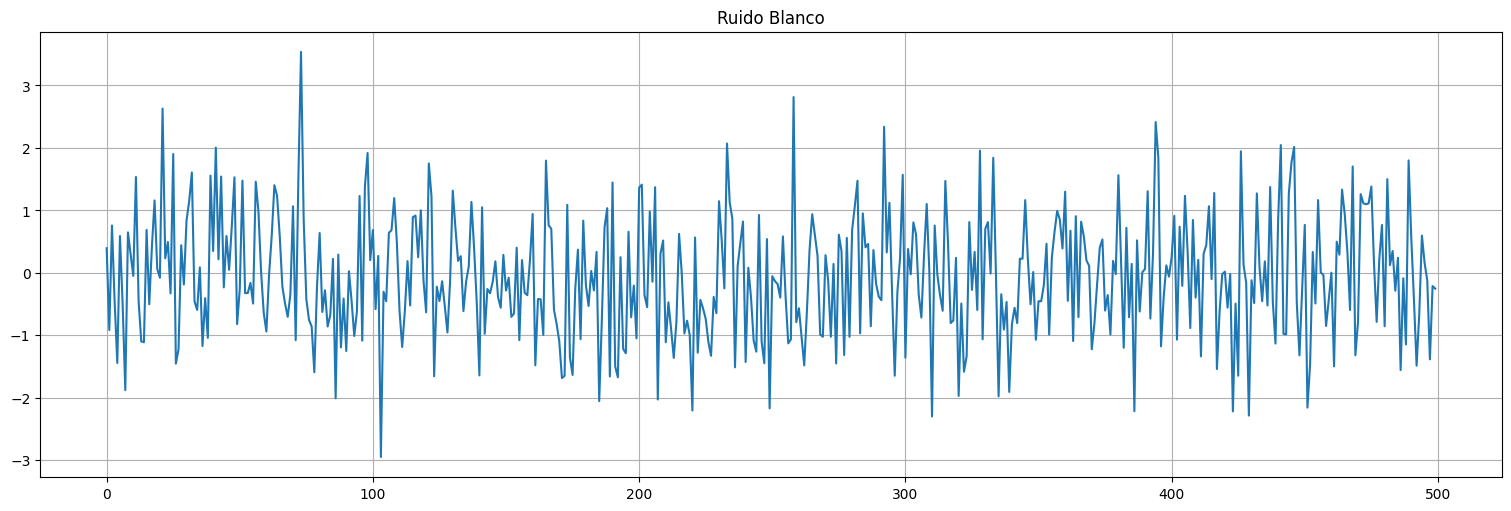

In [2]:
w = np.random.normal(loc=0,scale=1,size=500) #genero 500 muestras gaussianas
plt.plot(w)
plt.title("Ruido Blanco");

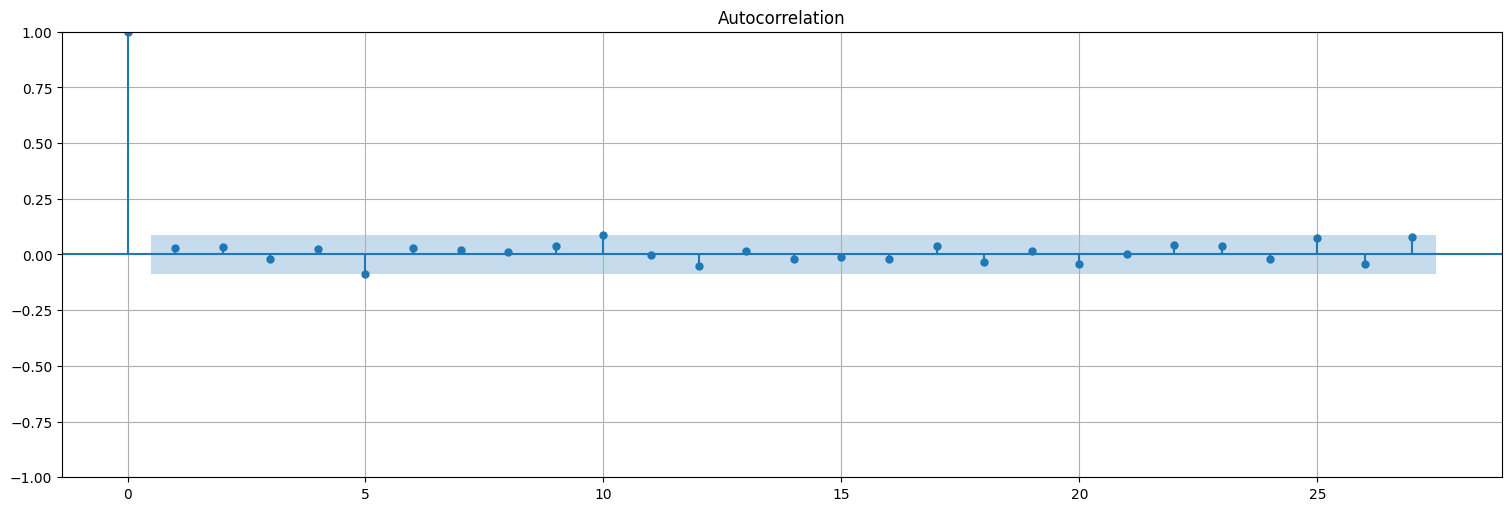

In [3]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(w, bartlett_confint=False);

## Modelos autorregresivos

**Definición:** un proceso autorregresivo de orden $p$ es un proceso en el cual el valor en tiempo $t$ es una combinación lineal de los últimos $p$ valores de la serie, más una *innovación* o *ruido* que afecta solo al tiempo $t$:

$$x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + \ldots + \phi_p x_{t-p} + w_t$$

con $x_0,\ldots,x_{p-1}$ especificados y $w_t$ ruido blanco (gaussiano) de varianza $\sigma_w^2$.

**Parametrización alternativa:**

Otra forma de escribir el mismo proceso es

$$a_0 x_t + a_1 x_{t-1} + \ldots + a_p x_{t-p} = b_0 w_t$$

con $a_0=1$, $a_i = -\phi_i$, $b_0=\sigma_w$ y en este caso $w_t$ es ruido blanco de varianza $1$. Esta es la parametrización que se utiliza en `Python`.

### Ejemplo:

Consideremos el proceso:

 $$x_t = x_{t-1} -0.9 x_{t-2} + w_t$$
 
 o bien
 
 $$x_t - x_{t-1} + 0.9x_{t-2} = w_t$$

 Con $x_{0}$ y $x_{-1}$ dados (por ejemplo 0) y $\sigma_w^2=1$.

Este es un proceso *autorregresivo de orden 2*. En este caso $a=(1,-1,0.9)$ y $b_0=\sigma_w = 1$.

Para simular una realización en `Python` podemos:

 * Generarlo a partir de una muestra de ruido blanco como la anterior, usando la función `lfilter` de `scipy.signal` como `scipy.signal.lfilter(b, a, x)`.
 * Generarlo directamente a partir de un objeto de tipo `statsmodels.tsa.ArmaProcess`.

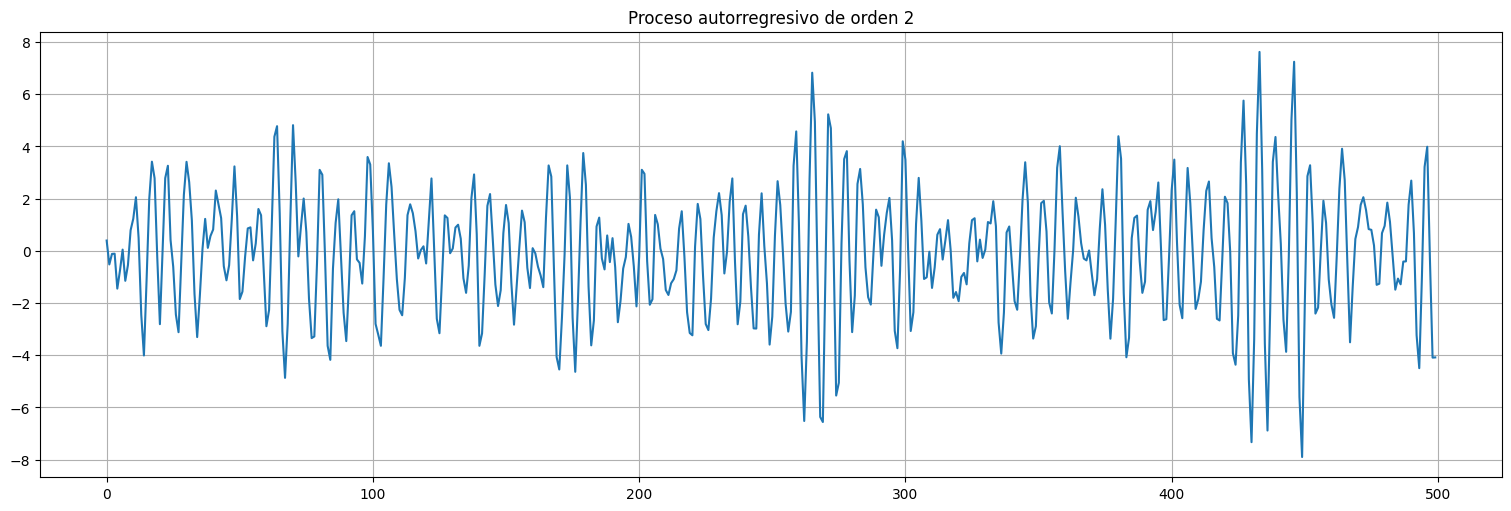

In [4]:
from scipy.signal import lfilter

x = lfilter([1],[1,-1,0.9],w)
plt.plot(x)
plt.title("Proceso autorregresivo de orden 2");

### Autocorrelación del proceso:

Uno tiende a pensar que la autocorrelación del proceso solo tendrá valores significativos para los 2 anteriores. **FALSO**

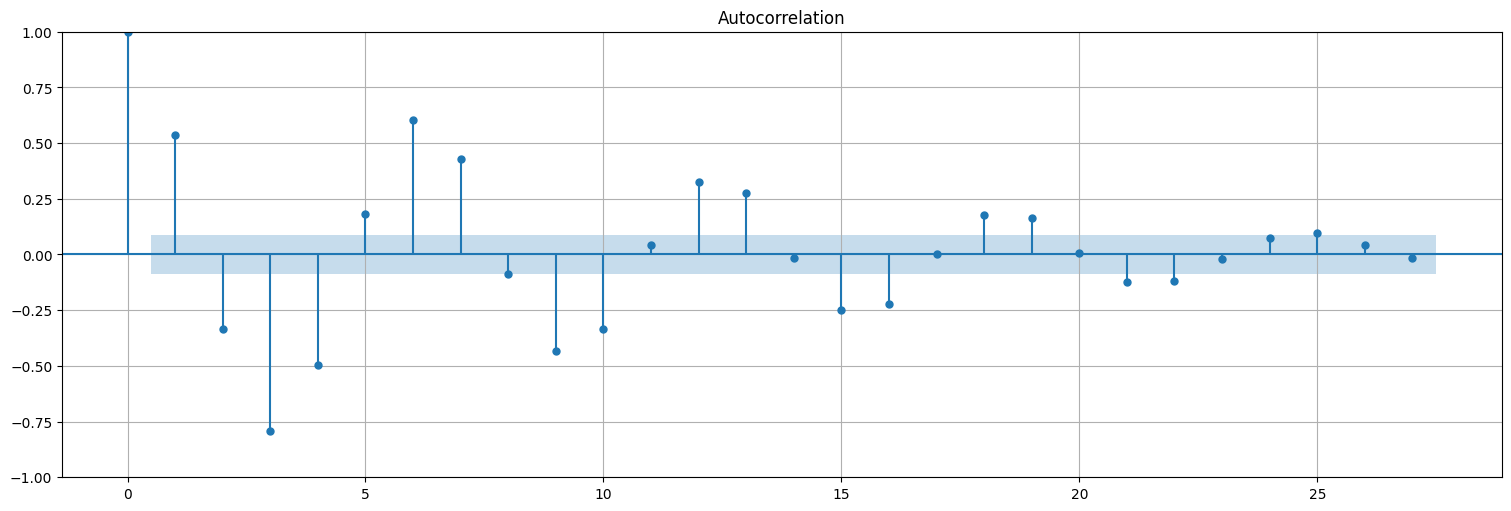

In [5]:
plot_acf(x, bartlett_confint=False);

## Ejemplo: autorregresivo de orden 1

Consideremos el proceso:
 $$x_t = 0.9 x_{t-1} + w_t.$$

 Con $x_{0}$ dado (por ejemplo 0).

Este es un proceso *autorregresivo de orden 1*. Cada muestra recuerda a la anterior.

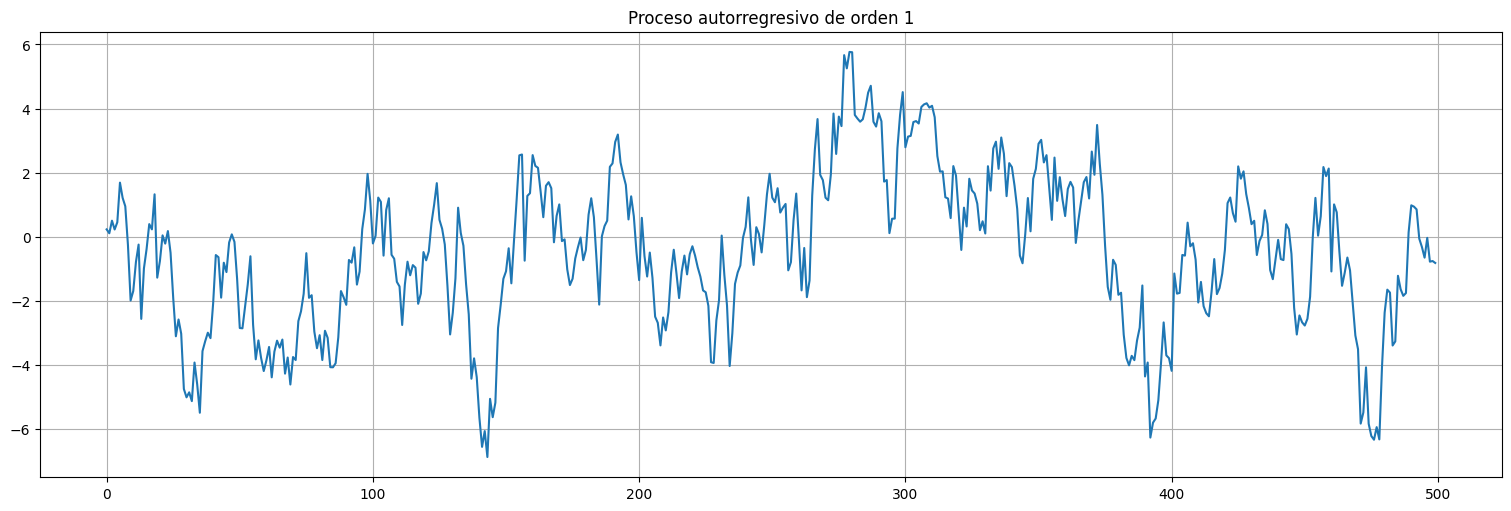

In [6]:
w = np.random.normal(loc=0,scale=1,size=500)
x = lfilter([1], [1,-0.9],w)
plt.plot(x)
plt.title("Proceso autorregresivo de orden 1");

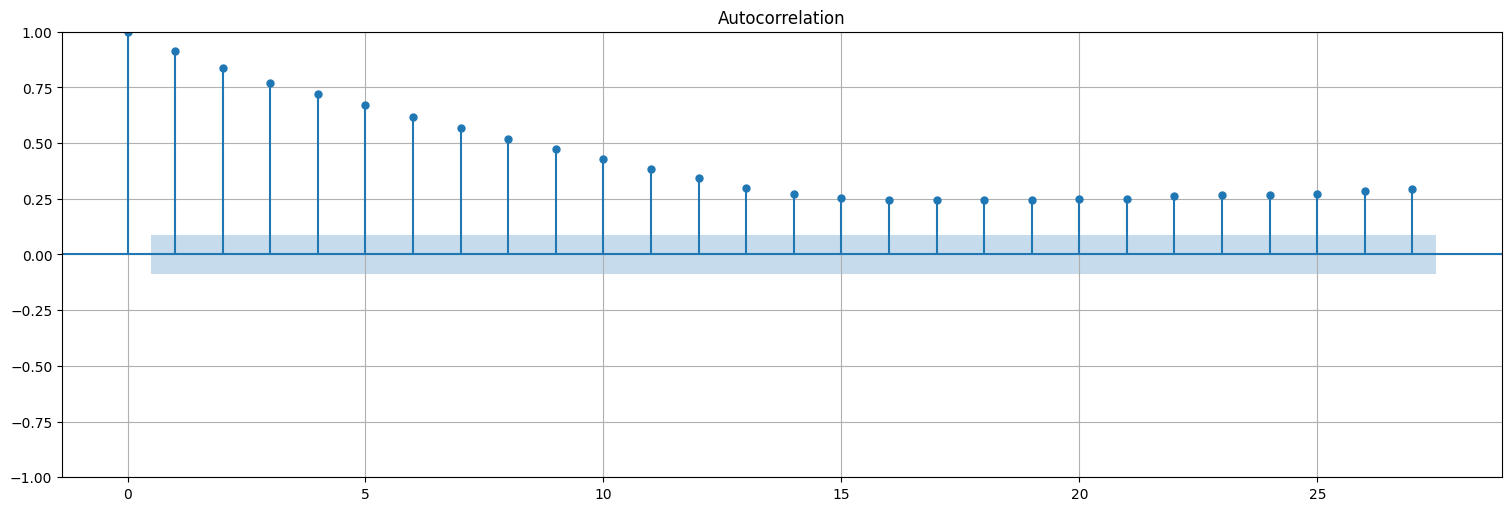

In [7]:
plot_acf(x, bartlett_confint=False);

**Pregunta:** ¿Cómo podemos determinar el orden de un proceso de este tipo? ¿Cómo podemos determinar sus parámetros?

## Ajuste de modelos autorregresivos.

### Estimación de un AR(1)

Supongamos que sabemos que el orden es conocido. Por ejemplo, para este caso, de orden $1$.

Probemos mirar la correlación entre un valor y el anterior:

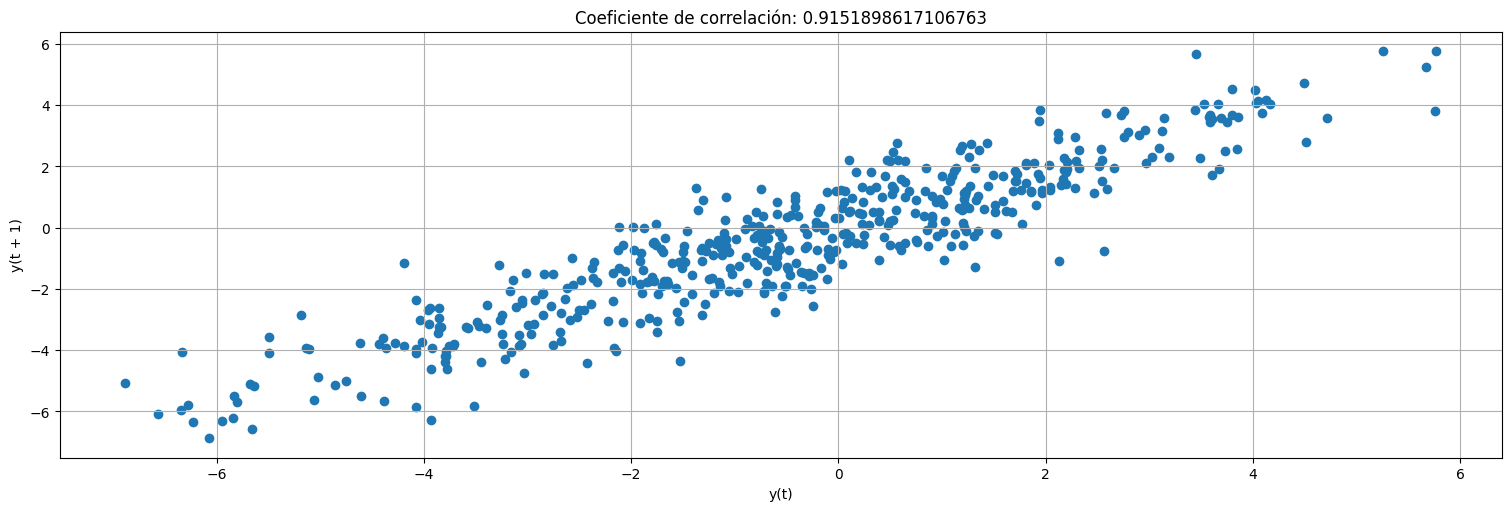

In [8]:
#Este comando de pandas plotea x_t vs x_t-1
x=pd.Series(x) #transformo x en una serie temporal
pd.plotting.lag_plot(x,lag=1);
plt.title(f"Coeficiente de correlación: {x.autocorr(1)}");

Más precisamente, podemos ajustar un modelo lineal entre los datos de la serie $x_t$ y la serie "laggeada":

In [9]:
from statsmodels.formula.api import ols
#Podemos llamar a fit haciendo referencia a las columnas de un dataframe.
data = pd.concat([x, x.shift(1)], axis=1).dropna()
data.columns = ["x", "xL1"]

fit = ols("x ~ 0+xL1", data=data).fit()
print(f"MSE de los residuos: {fit.mse_resid}")
fit.summary()

MSE de los residuos: 0.9355830439467617


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      x   R-squared (uncentered):                   0.844
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                              2694.
Date:                Mon, 19 May 2025   Prob (F-statistic):                   4.74e-203
Time:                        16:18:19   Log-Likelihood:                         -690.94
No. Observations:                 499   AIC:                                      1384.
Df Residuals:                     498   BIC:                                      1388.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
xL1            0.9188      0.018     51.907      0.000       0.884       0.954
==============================================================================
Omnibus:                        1.192   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.551   Jarque-Bera (JB):                1.012
Skew:                          -0.097   Prob(JB):                        0.603
Kurtosis:                       3.106   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

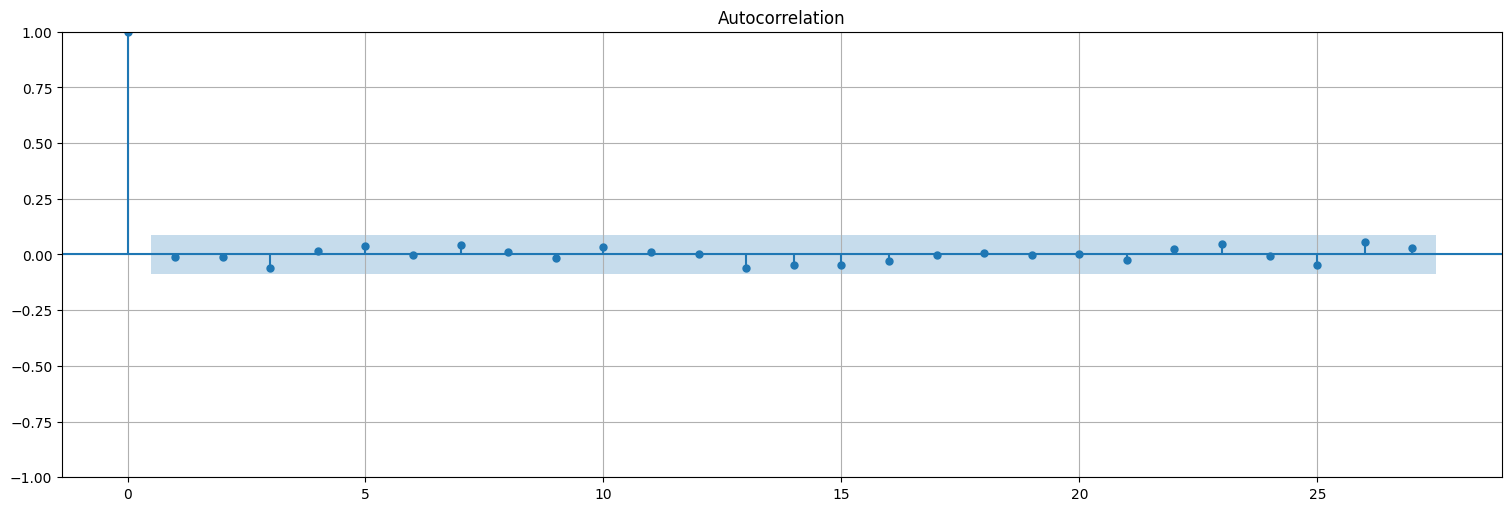

In [10]:
#Miramos los residuos del ajuste
residuos = fit.resid
plot_acf(residuos, bartlett_confint=False);

### Probemos ahora con el AR(2)

$$x_t = x_{t-1} - 0.9x_{t-2} + w_t.$$

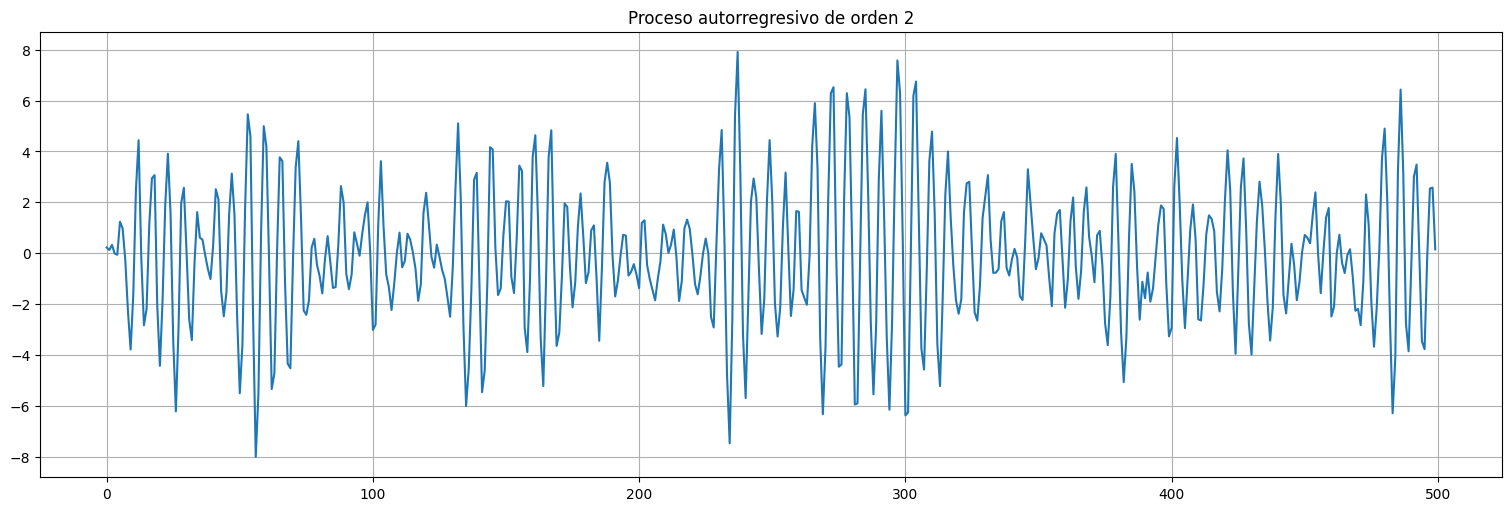

In [11]:
x = lfilter([1],[1,-1,0.9],w)
plt.plot(x)
plt.title("Proceso autorregresivo de orden 2");

Correlaciones con los dos lags anteriores:

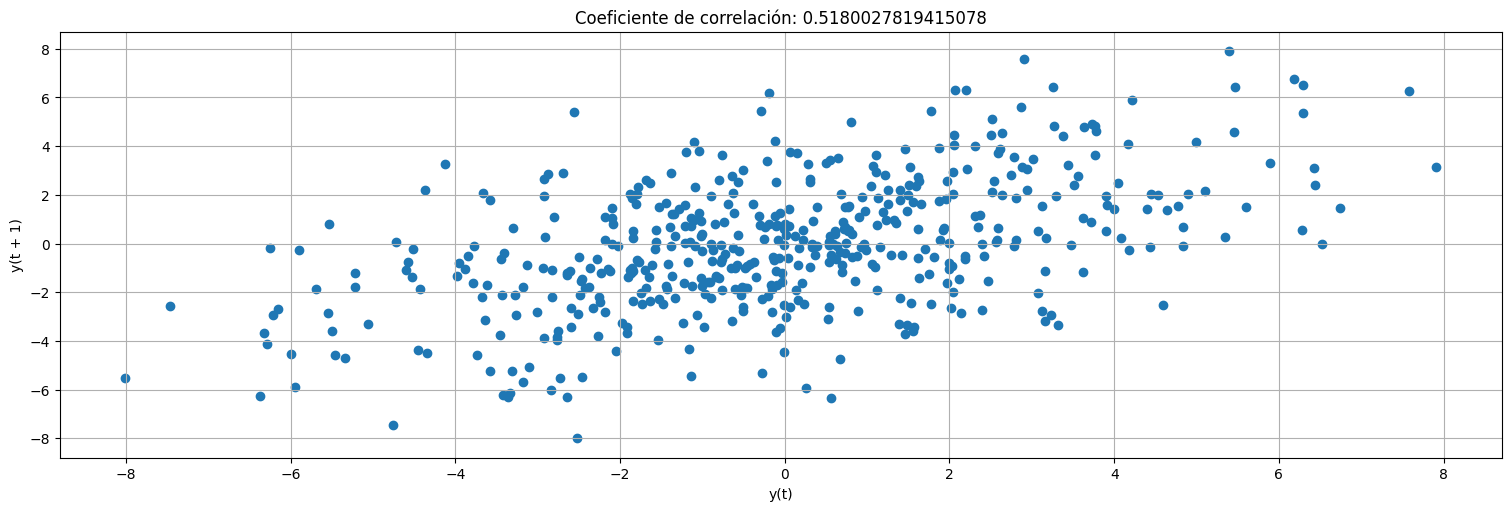

In [12]:
x=pd.Series(x) #transformo x en una serie temporal
pd.plotting.lag_plot(x,lag=1);
plt.title(f"Coeficiente de correlación: {x.autocorr(1)}");

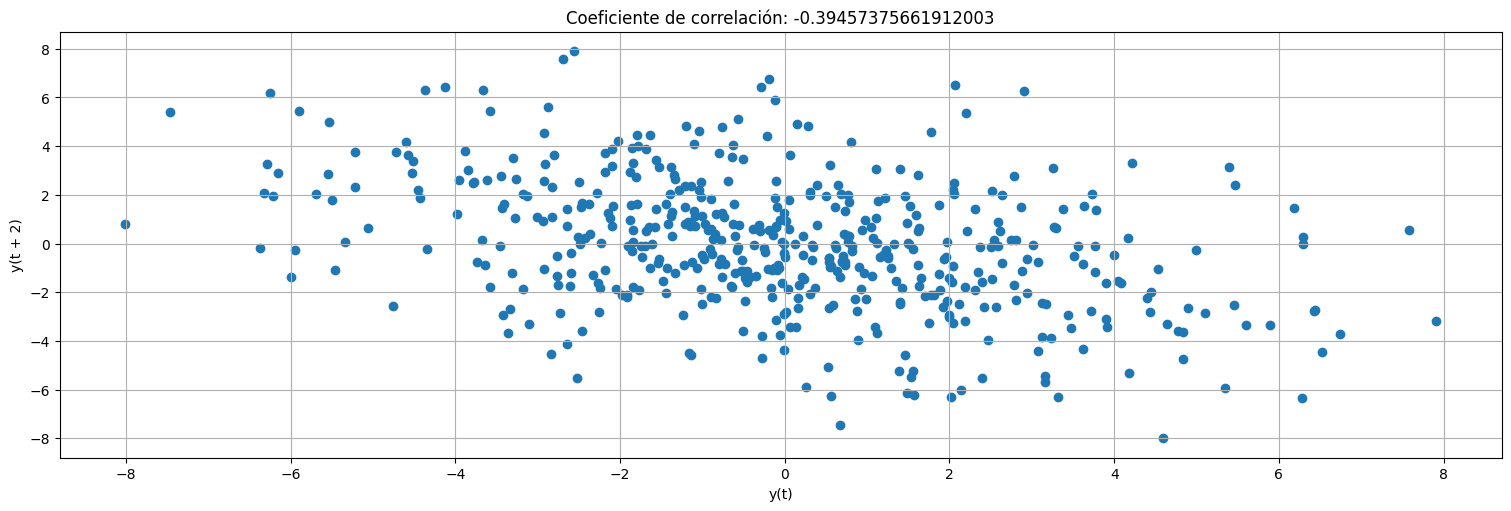

In [13]:
pd.plotting.lag_plot(x,lag=2);
plt.title(f"Coeficiente de correlación: {x.autocorr(2)}");

Nuevamente, ajustamos por mínimos cuadrados un modelo lineal a la serie $x_t$ en función de los dos lags anteriores:

In [14]:
x=pd.Series(x)
data = pd.concat([x, x.shift(1), x.shift(2)], axis=1).dropna()
data.columns = ["x", "xL1", "xL2"]

fit = ols("x ~ 0+xL1+xL2", data=data).fit()
print(f"MSE de los residuos: {fit.mse_resid}")
fit.summary()

MSE de los residuos: 0.9394490858244653


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      x   R-squared (uncentered):                   0.869
Model:                            OLS   Adj. R-squared (uncentered):              0.869
Method:                 Least Squares   F-statistic:                              1648.
Date:                Mon, 19 May 2025   Prob (F-statistic):                   8.18e-220
Time:                        16:18:20   Log-Likelihood:                         -690.08
No. Observations:                 498   AIC:                                      1384.
Df Residuals:                     496   BIC:                                      1393.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
xL1            0.9882      0.019     52.035      0.000       0.951       1.026
xL2           -0.9073      0.019    -47.728      0.000      -0.945      -0.870
==============================================================================
Omnibus:                        1.013   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.603   Jarque-Bera (JB):                0.862
Skew:                          -0.094   Prob(JB):                        0.650
Kurtosis:                       3.079   Cond. No.                         1.78
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Los residuos quedan sin autocorrelación (ruido blanco):

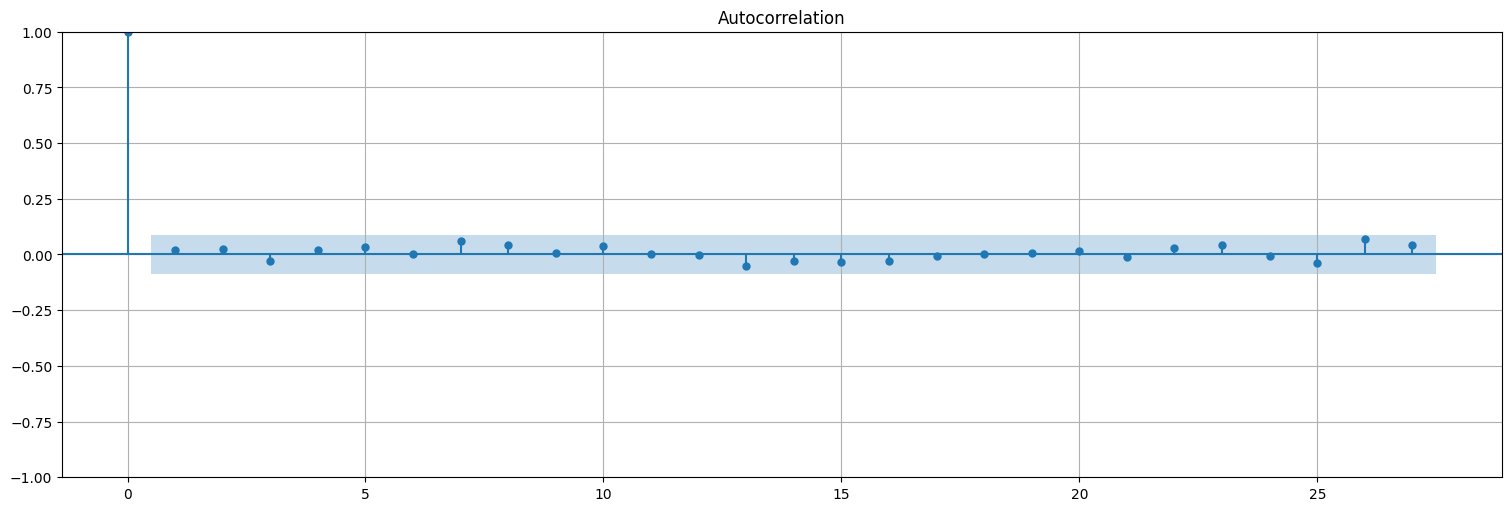

In [15]:
plot_acf(fit.resid, bartlett_confint=False);

Podemos ver además que los residuos siguen una distribución gaussiana:

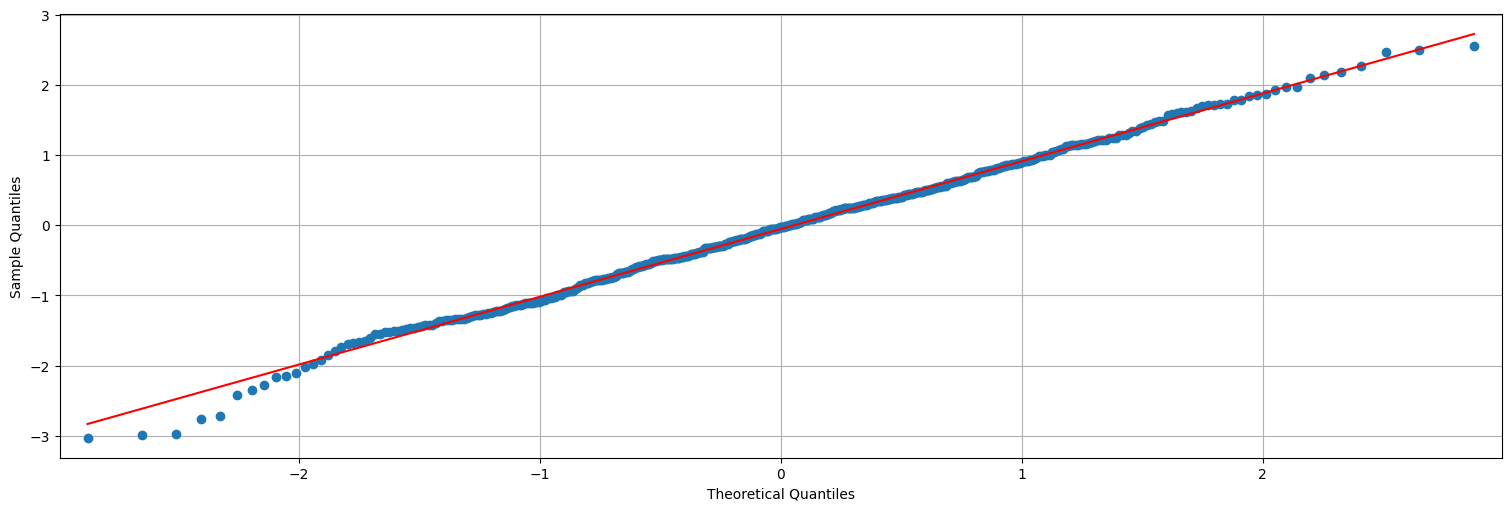

In [16]:
from statsmodels.graphics.api import qqplot
qqplot(fit.resid,line='s');

De hecho, si el ajuste es bueno, los **residuos** del ajuste deberían parecerse al ruido blanco que dio origen a la serie:

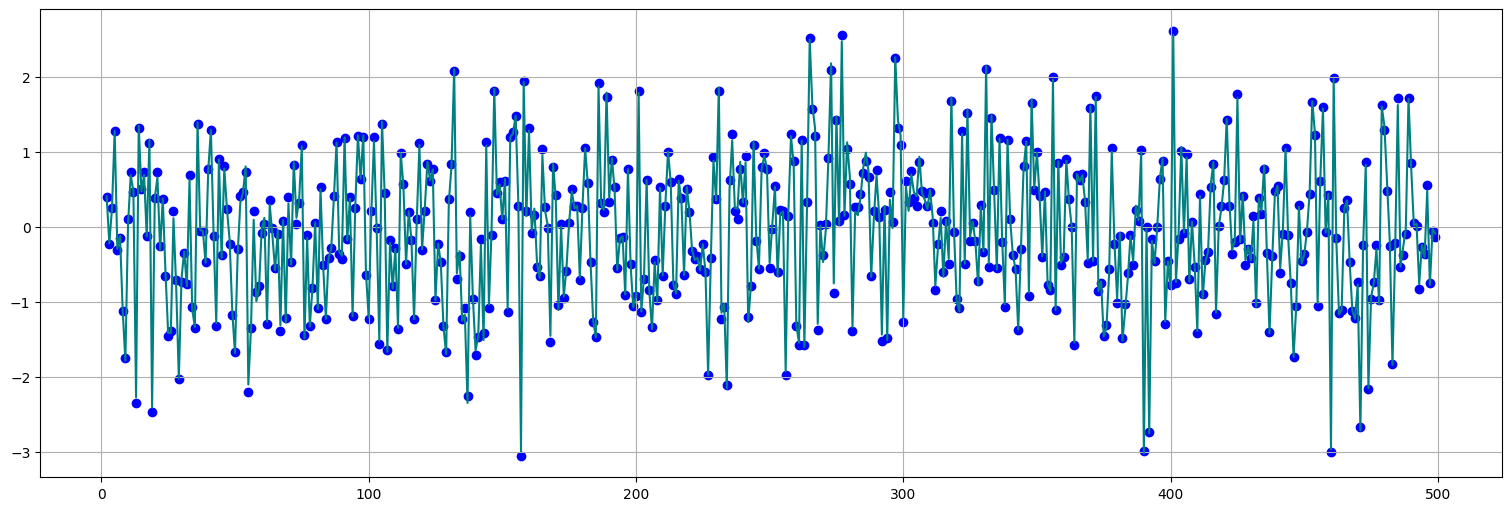

In [17]:
plt.plot(fit.resid, color="teal")
plt.scatter(fit.resid.index, w[2:], color="blue");

### Conclusiones:

* En un modelo AR(p), cada muestra depende del ruido actual y de una combinación lineal de las observaciones anteriores

* La autocorrelación de todos modos depende de todas las muestras que vinieron antes!

* **Si conocemos el *orden* del modelo**, podemos hacer una regresión lineal para explicar $x_t$ a partir de $x_{t-1}$ hasta $x_{t-p}$. De ese modo se obtienen los valores de los coeficientes. *Pregunta:* ¿Cuál es el orden adecuado?

* Si el proceso ajusta, los residuos deberían ser aproximadamente ruido blanco y parecerse al ruido que dio origen a la serie.

## Función de autocorrelación parcial (PACF)

**Idea:** construir una función de correlación que solo contenga los aportes "incrementales" de agregar un lag, y no la correlación completa.

Se explica mejor a través de un ejemplo, dejaremos la teoría para más adelante.

Retomemos la serie:

$$x_t = x_{t-1} - 0.9 x_{t-2} + w_t.$$

Recordemos la función de autocorrelación (ACF)

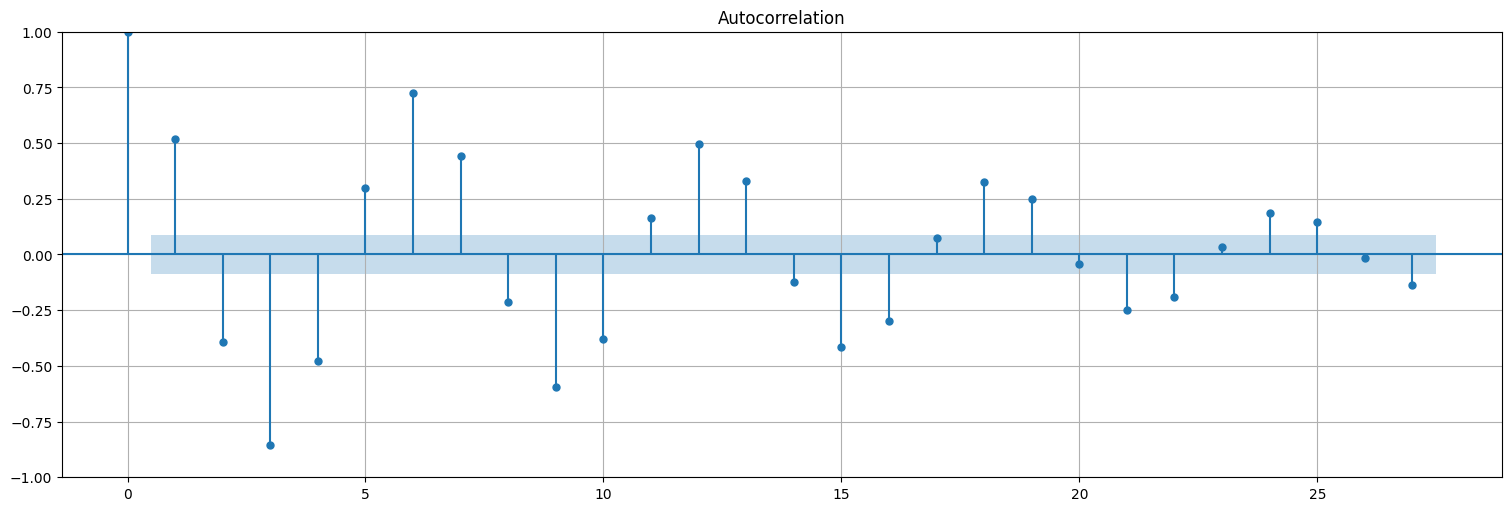

In [18]:
plot_acf(x, bartlett_confint=False);

**Paso 1:** Ajustamos $x_t$ a $x_{t-1}$:

In [19]:
#Corto la serie x con la serie x laggeada
data = pd.concat([x, x.shift(1)], axis=1).dropna()
data.columns = ["x", "xL1"]
#Ajusto
fit = ols("x ~ 0+xL1", data=data).fit()
fit.summary() #el coef. hallado es la correlación de xt y xt-1, es decir acf(1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      x   R-squared (uncentered):                   0.269
Model:                            OLS   Adj. R-squared (uncentered):              0.267
Method:                 Least Squares   F-statistic:                              182.8
Date:                Mon, 19 May 2025   Prob (F-statistic):                    1.05e-35
Time:                        16:18:20   Log-Likelihood:                         -1120.5
No. Observations:                 499   AIC:                                      2243.
Df Residuals:                     498   BIC:                                      2247.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
xL1            0.5182      0.038     13.521      0.000       0.443       0.593
==============================================================================
Omnibus:                        0.037   Durbin-Watson:                   1.061
Prob(Omnibus):                  0.982   Jarque-Bera (JB):                0.018
Skew:                           0.014   Prob(JB):                        0.991
Kurtosis:                       2.996   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

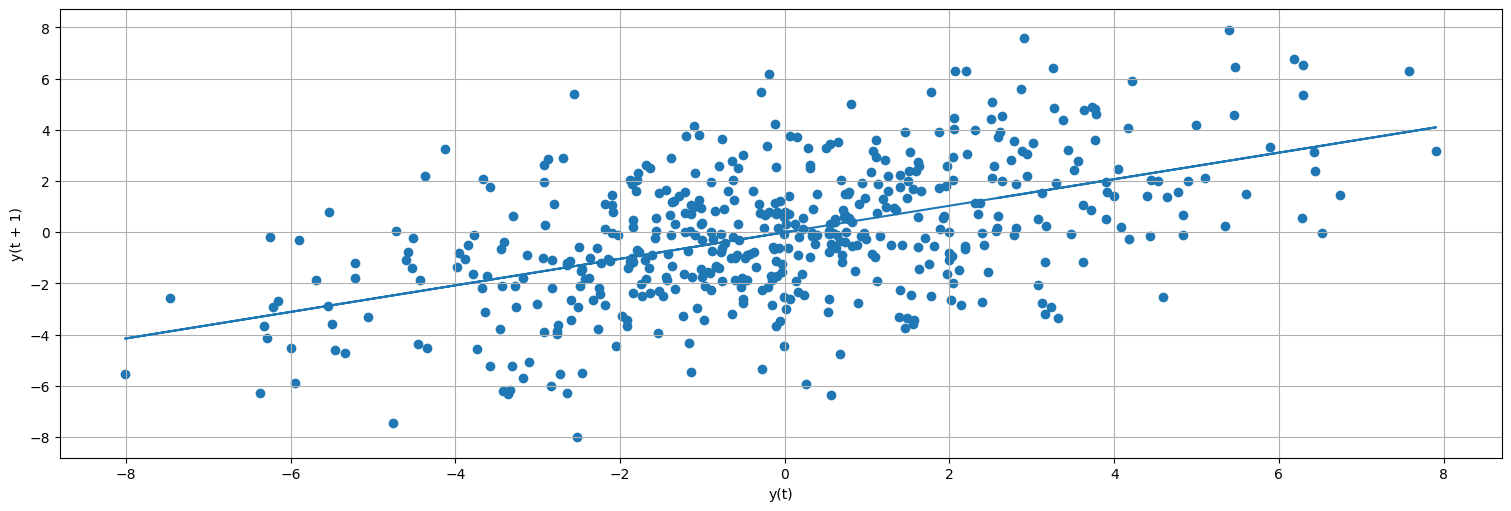

In [20]:
pd.plotting.lag_plot(x,lag=1);
plt.plot(x[0:-1],fit.fittedvalues);

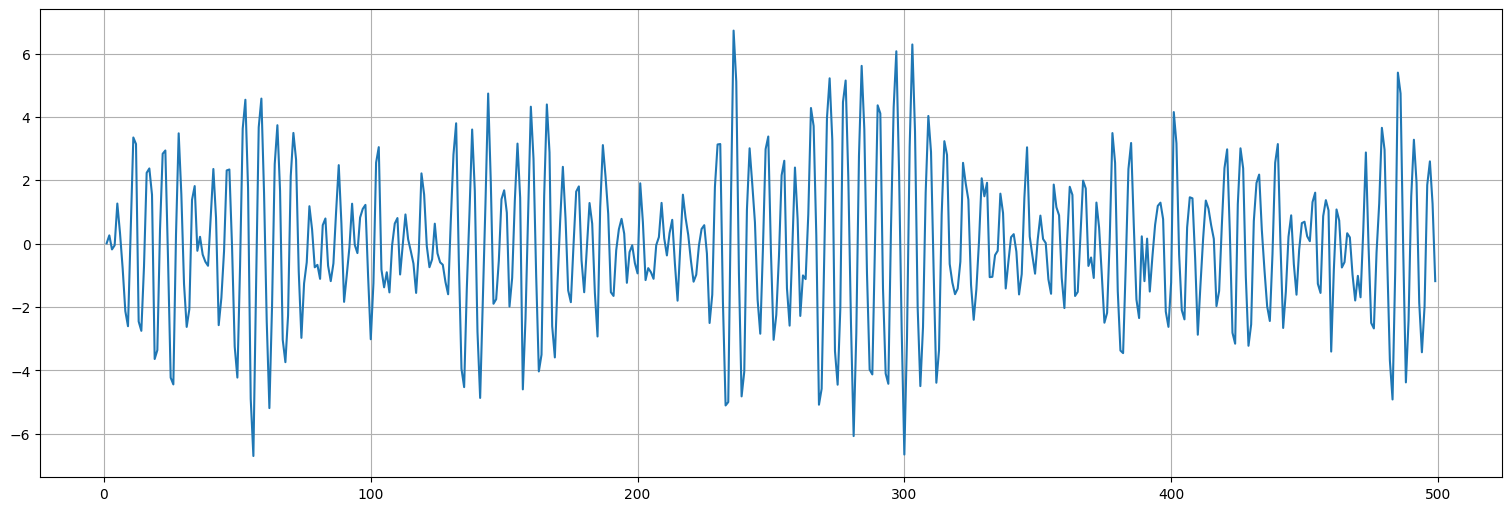

In [21]:
#capturo los residuos del ajuste anterior
r1 = fit.resid
r1.plot();

* Si el proceso fuera de orden $1$, entonces una vez que conozco $x_{t-1}$, $x_t$ queda determinado a menos del ruido, por lo que el residuo no debería tener información.

* La serie anterior todavía no está del todo "blanca" quiere decir que debemos seguir un paso más.

* Problema: no alcanza con mirar otro lag, debemos "extraer" la información de $x_{t-2}$ que persiste en $x_t$.

* Para ello, miramos los residuos de los dos ajustes siguientes:

    * Ajusto $x_t$ a $x_{t-1}$, obtengo $r_1$ (es el mismo de antes).
    * Ajusto $x_{t-2}$ a $x_{t-1}$ para extraer la info propia de $x_{t-2}$. Obtengo $r_2$.
    * Calculo la correlación entre $r_1$ y $r_2$ (o bien ajusto lineal $r_2$ a $r_1$, es lo mismo). Al resultado se le llama *autocorrelación parcial* entre $x_t$ y $x_{t-2}$ (o de lag 2).

In [22]:
#Realizo el procedimiento anterior
data = pd.concat([x, x.shift(1), x.shift(2)], axis=1).dropna()
data.columns = ["x", "xL1", "xL2"]
#Ajusto r1
fit1 = ols("x ~ 0+xL1", data=data).fit()
r1=fit1.resid
fit1.summary() #el coef. hallado es la correlación de xt y xt-1, es decir acf(1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      x   R-squared (uncentered):                   0.269
Model:                            OLS   Adj. R-squared (uncentered):              0.267
Method:                 Least Squares   F-statistic:                              182.4
Date:                Mon, 19 May 2025   Prob (F-statistic):                    1.24e-35
Time:                        16:18:21   Log-Likelihood:                         -1118.7
No. Observations:                 498   AIC:                                      2239.
Df Residuals:                     497   BIC:                                      2244.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
xL1            0.5182      0.038     13.507      0.000       0.443       0.594
==============================================================================
Omnibus:                        0.030   Durbin-Watson:                   1.061
Prob(Omnibus):                  0.985   Jarque-Bera (JB):                0.020
Skew:                           0.015   Prob(JB):                        0.990
Kurtosis:                       2.990   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
#Ajusto r2
fit2 = ols("xL2 ~ 0+xL1", data=data).fit()
r2=fit2.resid
fit2.summary() #el coef. hallado es la correlación de xt y xt-1, es decir acf(1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    xL2   R-squared (uncentered):                   0.269
Model:                            OLS   Adj. R-squared (uncentered):              0.267
Method:                 Least Squares   F-statistic:                              182.8
Date:                Mon, 19 May 2025   Prob (F-statistic):                    1.08e-35
Time:                        16:18:21   Log-Likelihood:                         -1118.1
No. Observations:                 498   AIC:                                      2238.
Df Residuals:                     497   BIC:                                      2242.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
xL1            0.5181      0.038     13.520      0.000       0.443       0.593
==============================================================================
Omnibus:                        0.586   Durbin-Watson:                   1.062
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.425
Skew:                           0.051   Prob(JB):                        0.809
Kurtosis:                       3.100   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

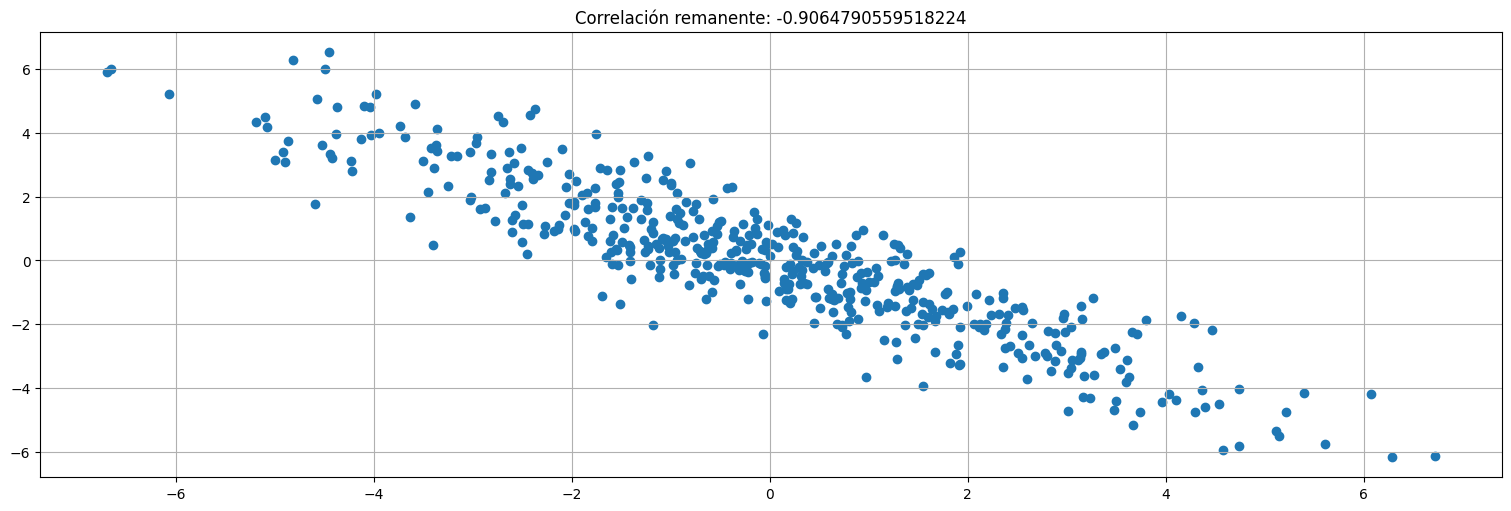

In [24]:
plt.scatter(r1,r2);
plt.title(f"Correlación remanente: {np.corrcoef(r1,r2)[0,1]}");

El método anterior puede repetirse para todos los lags. Simplemente:

 * Ajusto $x_t$ a $x_{t-1},\ldots,x_{t-p+1}$, obtengo $r_1$.
 * Ajusto $x_{t-p}$ a $x_{t-1},\ldots,x_{t-p+1}$, obtengo $r_2$.
 * Calculo la correlación entre $r_1$ y $r_2$ (o bien ajusto lineal $r_2$ a $r_1$, es lo mismo). Al resultado se le llama *autocorrelación parcial* entre $x_t$ y $x_{t-p}$ (o de lag $p$).
 
 Hagamoslo un paso más ($p=3$) para ver que ya no queda información.

In [25]:
#Realizo el procedimiento anterior
#Realizo el procedimiento anterior
data = pd.concat([x, x.shift(1), x.shift(2), x.shift(3)], axis=1).dropna()
data.columns = ["x", "xL1", "xL2", "xL3"]
#Ajusto r1
fit1 = ols("x ~ 0+xL1+xL2", data=data).fit()
r1=fit1.resid
#Ajusto r2
fit2 = ols("xL3 ~ 0+xL1+xL2", data=data).fit()
r2=fit2.resid

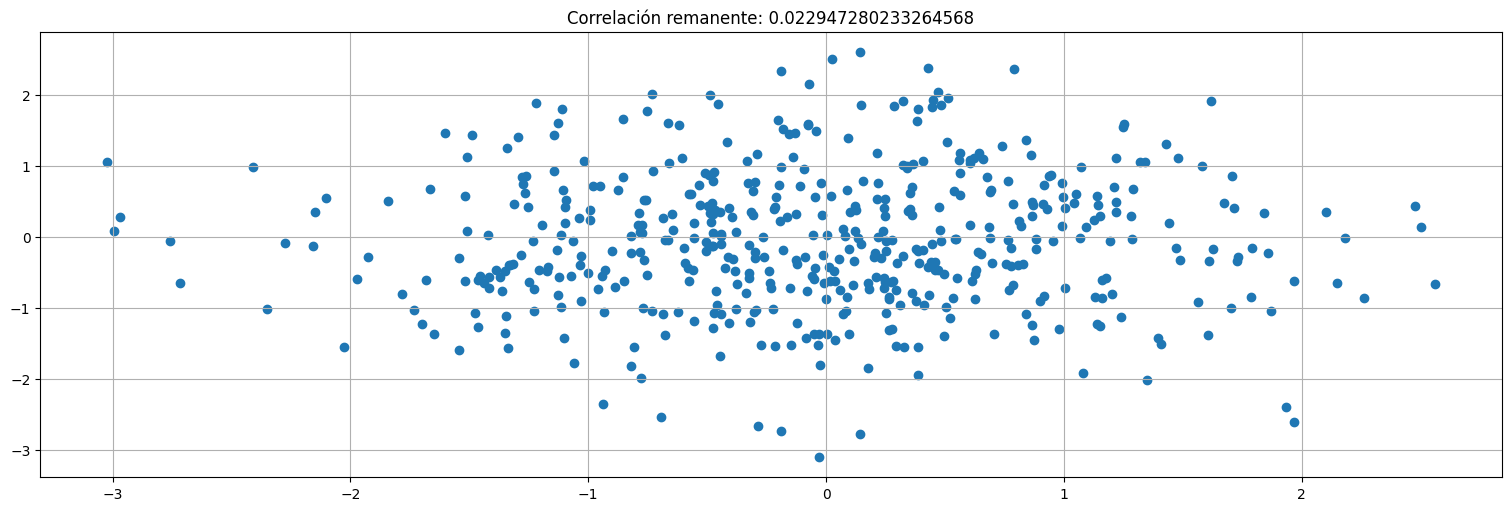

In [26]:
plt.scatter(r1,r2);
plt.title(f"Correlación remanente: {np.corrcoef(r1,r2)[0,1]}");

### Función de autocorrelación parcial (PACF)

* A la función así construida recursivamente se le denomina Función de Autocorrelación Parcial (PACF).
* En el ejemplo anterior, la PACF(1) coincide con la ACF(1). La PACF(2) *NO* (es otra información).
* En el proceso AR(2), la PACF(2) era significativa, la PACF(3) se vuelve 0.
* En general, si un proceso es AR($p$), entonces la PACF se "apaga" luego de $p$.

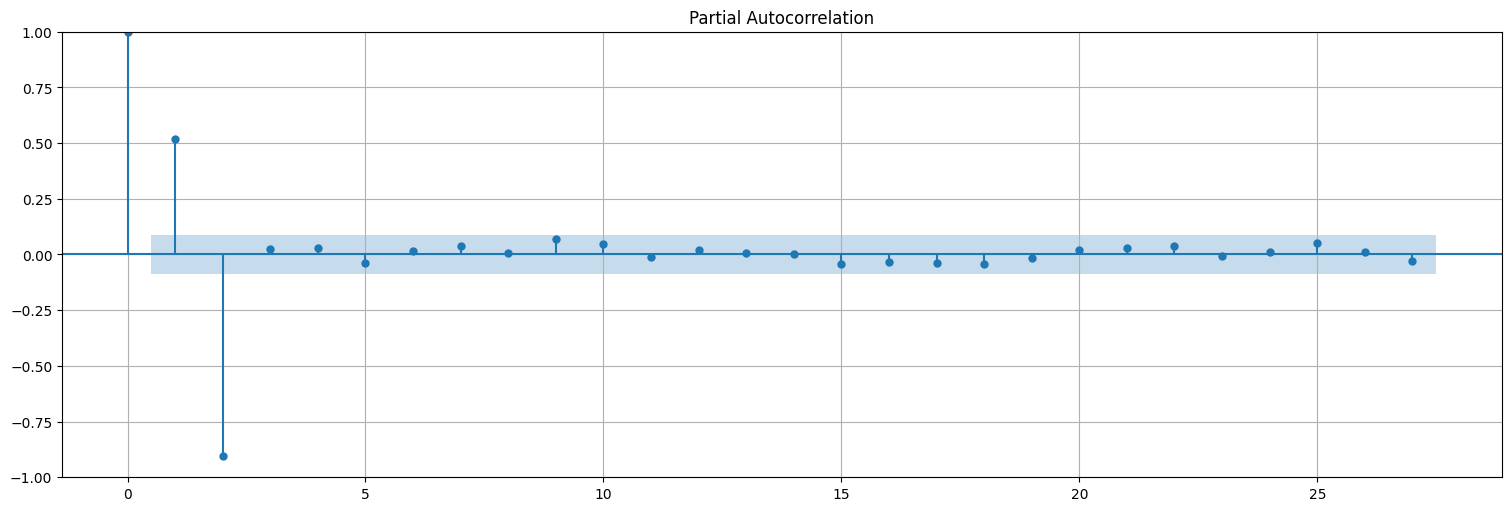

In [27]:
plot_pacf(x);

Apliquemos la misma idea al proceso AR(1) que teníamos antes

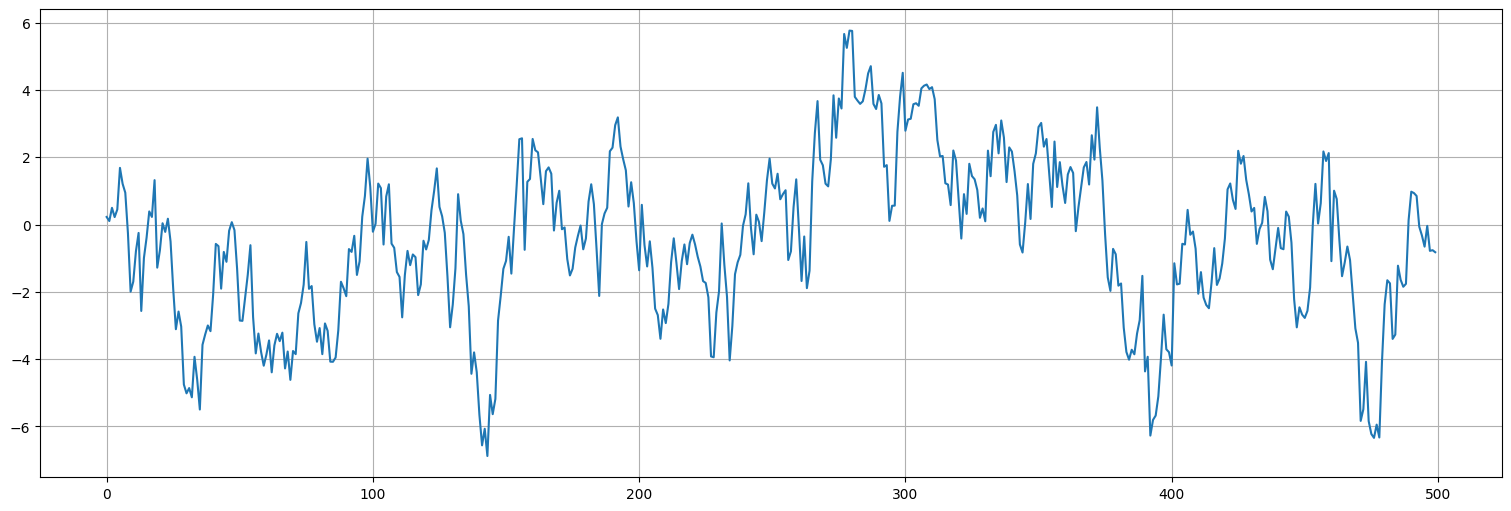

In [28]:
#esto se construye con el comando "filter" de R
x = lfilter([1],[1,-.9], w)
plt.plot(x);

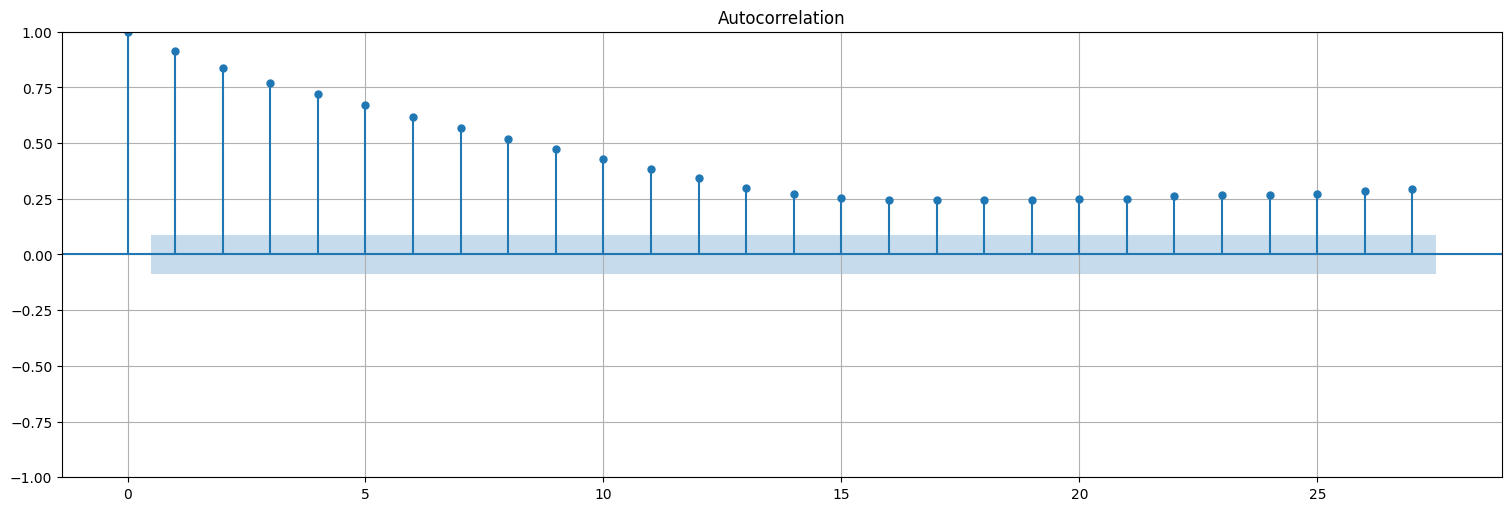

In [29]:
plot_acf(x,bartlett_confint=False);

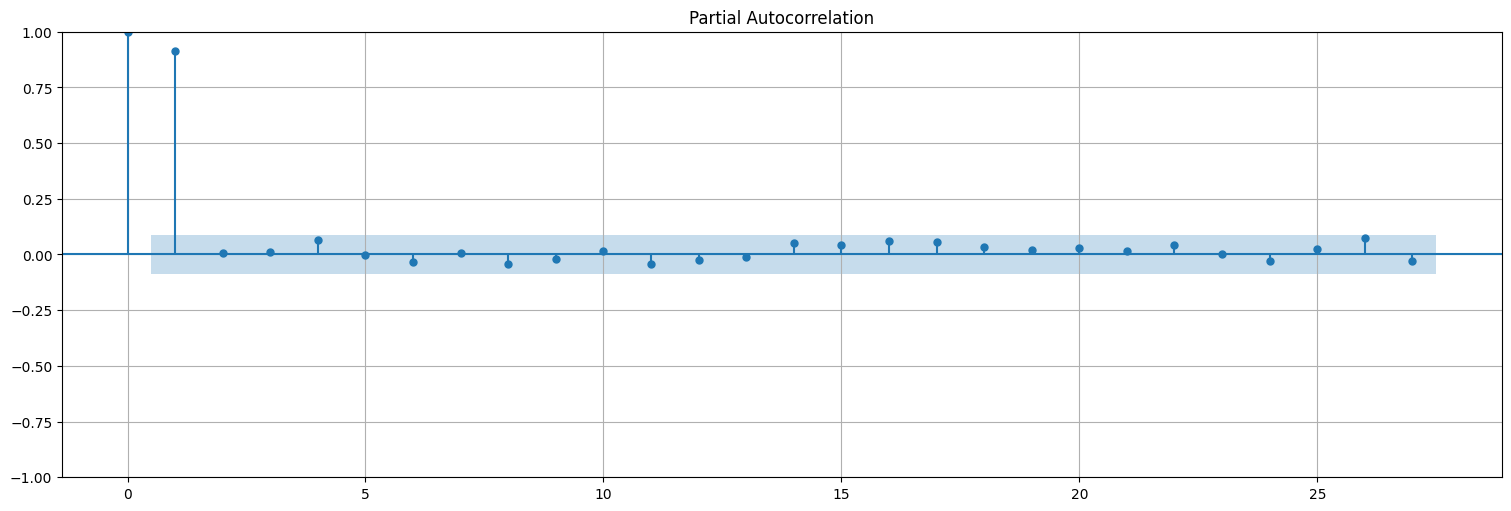

In [30]:
plot_pacf(x);

## Resumen

* En un proceso autorregresivo puro, el valor de la serie en tiempo $t$ depende de los $p$ anteriores más una innovación o ruido en ese punto.

* Por lo tanto, todas las muestras anteriores tienen influencia en la muestra actual (aunque decae exponencialmente).

* La función de autocorrelación entonces decae a $0$ exponencialmente, pero no se anula.

* La función de autocorrelación *parcial* elimina las dependencias internas y permite estimar el orden de un autorregresivo puro.

* *Una vez que conocemos el orden*, podemos hacer regresión para hallar los coeficientes y el $\sigma^2_w$. 
`fit<- lm(x~xt1+xt2+xt3...)`

## Predicción a futuro

El siguiente paso es, una vez ajustado un proceso autorregresivo, predecir sus valores a futuro.

Idealmente, queremos hallar:
$$\hat{x}_{n+m} = g(x_1,\ldots,x_n)$$
de modo que:
$$MSE = E[(x_{n+m} - \hat{x}_{n+m})^2]$$
se minimice.


El estimador ideal es la esperanza condicional:

$$\hat{x}_{n+m} = E[x_{n+m} \mid x_1,\ldots,x_n]$$

En el caso de procesos lineales ARMA, este estimador se puede calcular mediante el algoritmo de Durbin-Levinson. Sin embargo, en el caso del autorregresivo puro es más simple. Una vez que se conocen los parámetros del modelo:

$$x_{t} = \phi_1 x_{t-1} + \phi_2 x_{t-2} + \ldots + \phi_p x_{t-p} + w_t.$$

Entonces la mejor predicción de $x_{p+1}$ es simplemente realizar la combinación lineal de los últimos $p$ valores:
$$\hat{x}_{n+1} = \phi_1 x_{n} + \phi_2 x_{n-1} + \ldots + \phi_p x_{n-p+1}$$

y luego recursivamemte se pueden construir las estimaciones de $x_{n+2},x_{n+3},\ldots$ etc.

$$\hat{x}_{n+2} = \phi_1 \hat{x}_{n+1} + \phi_2 x_{n} + \ldots + \phi_p x_{n-p+2}$$


### Ejemplo:

Para este ejemplo, simularemos directamente el proceso AR(2) usando una función de Python en lugar de construirlo a partir de una serie de ruido blanco conocida:

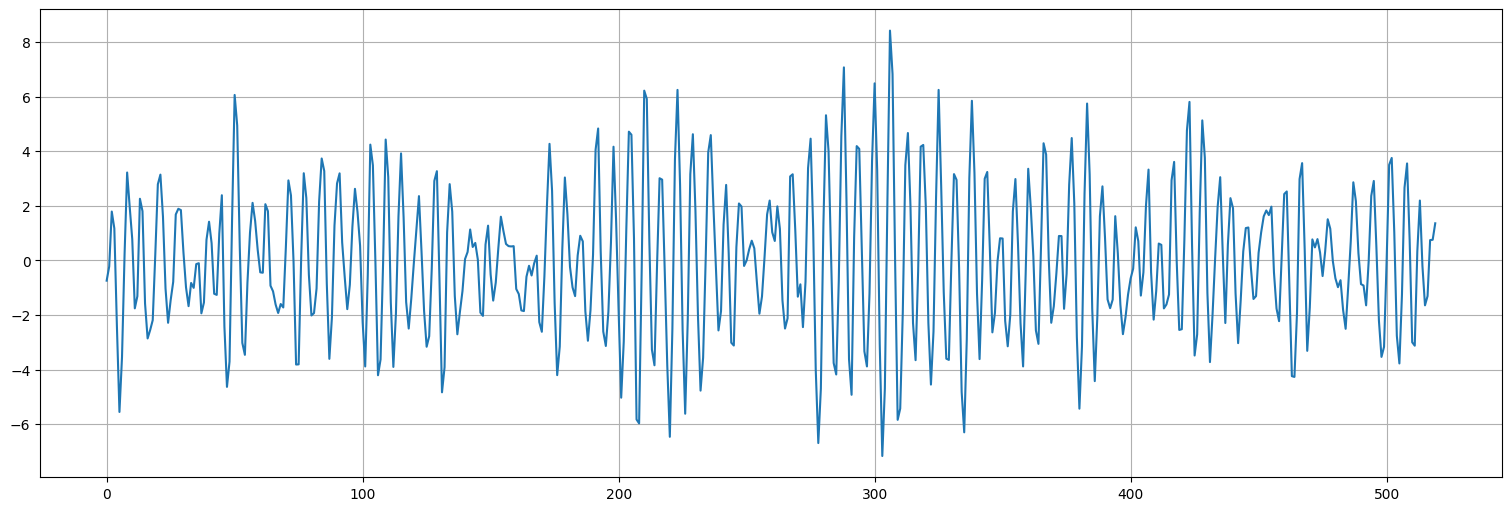

In [31]:
##Simulamos un AR(2) usando ahora la función propia de statsmodels
from statsmodels.tsa.arima_process import arma_generate_sample

#primer parámetro: coeficientes autorregresivos. Segundo parámetro: coeficientes de media móvil
#Para el AR puro este segundo parámetro es 1
#El tercer parámetro es la cantidad de muestras.
n=500; #train
m=20; #test
x=arma_generate_sample([1,-1,.9],[1],n+m)

#lo transformo en una serie para poder hacer shift
x=pd.Series(x)
x.plot();

Ajustamos los coeficientes con los primeros 500 datos y predecimos los otros 20.

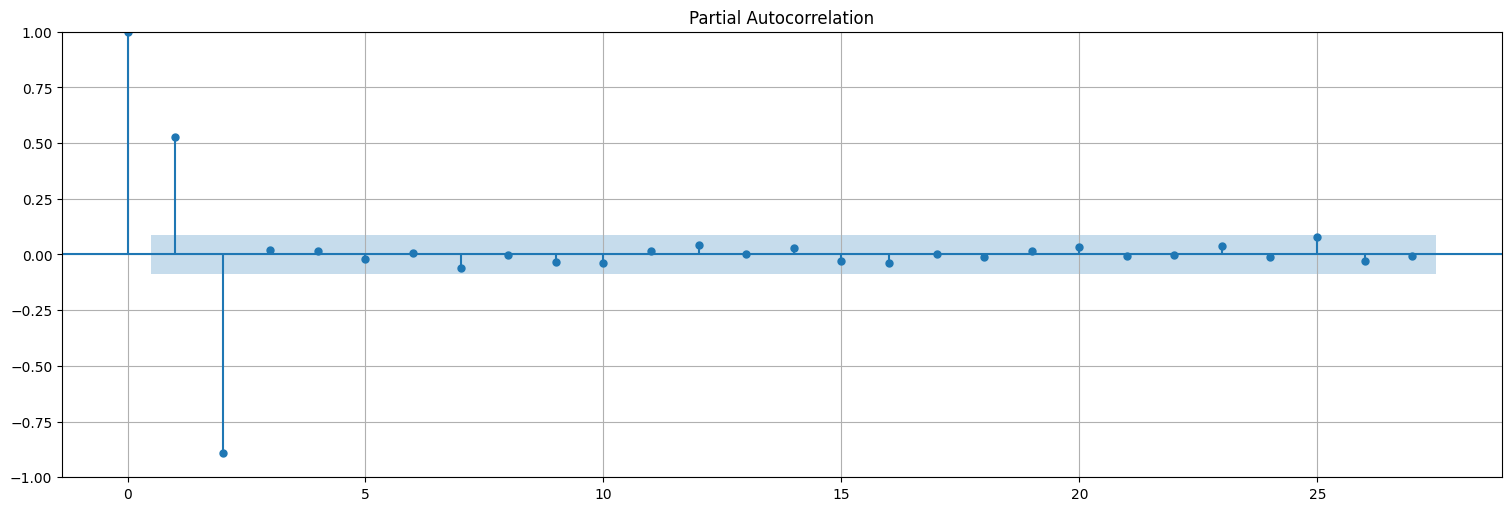

In [32]:
## Recorto la serie
x_train = x.iloc[0:n]
## Chequeo la PACF
plot_pacf(x_train);

In [33]:
#Estimo los coeficientes por regresión en el conjunto de train
data = pd.concat([x_train, x_train.shift(1), x_train.shift(2)], axis=1).dropna()
data.columns = ["x", "xL1", "xL2"]
#Ajusto
fit = ols("x ~ 0+xL1+xL2", data=data).fit()
residuo=fit.resid
fit.summary() #el coef. hallado es la correlación de xt y xt-1, es decir acf(1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      x   R-squared (uncentered):                   0.854
Model:                            OLS   Adj. R-squared (uncentered):              0.854
Method:                 Least Squares   F-statistic:                              1455.
Date:                Mon, 19 May 2025   Prob (F-statistic):                   2.96e-208
Time:                        16:18:22   Log-Likelihood:                         -711.99
No. Observations:                 498   AIC:                                      1428.
Df Residuals:                     496   BIC:                                      1436.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
xL1            1.0011      0.020     49.568      0.000       0.961       1.041
xL2           -0.8950      0.020    -44.238      0.000      -0.935      -0.855
==============================================================================
Omnibus:                        2.616   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.270   Jarque-Bera (JB):                2.496
Skew:                          -0.106   Prob(JB):                        0.287
Kurtosis:                       3.274   Cond. No.                         1.80
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
phi1 = fit.params["xL1"]
phi2 = fit.params["xL2"]

print("Coeficientes estimados:")
print(f"phi1: {phi1}")
print(f"phi2: {phi2}")

Coeficientes estimados:
phi1: 1.001125252883416
phi2: -0.8950251720111233


In [35]:
#Construyo la prediccion recursiva
x_test = x.iloc[n:]
x_hat = np.empty(m)

x_hat[0] = phi1 * x_train[n-1] + phi2*x_train[n-2]
x_hat[1] = phi1 * x_hat[0] + phi2*x_train[n-1]

for i in range(2,m):
    x_hat[i] = phi1 * x_hat[i-1] + phi2*x_hat[i-2]

#lo convierto en una serie
x_hat = pd.Series(x_hat,index=range(n,n+m))

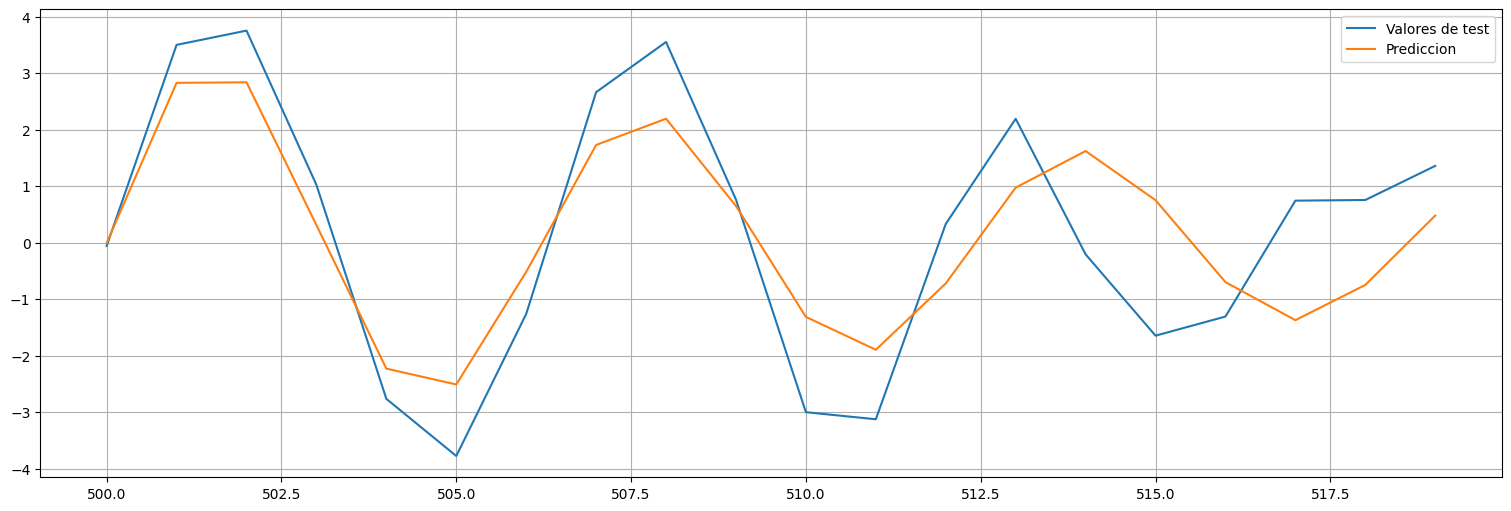

In [36]:
plt.plot(x_test, label="Valores de test")
plt.plot(x_hat, label="Prediccion");
plt.legend();

**Observaciones:**

* La predicción solo es razonable a pocos intervalos.
* A la larga vuelve a la media ya que promedia los valores que va obteniendo.
* Dicho de otro modo, como la influencia de los datos hasta $n$ decae exponencialmente después de $n$, es muy difícil predecir más allá de unos pocos pasos.

### Predicción recursiva

De todos modos, si bien no permite predecir mucho hacia el futuro, podemos ir recursivamente prediciendo el valor $x_{n+1}$ una vez que conocemos $x_{n},x_{n-1},\ldots,x_{n-p+1}$, es decir los últimos $p$.

Luego si recibimos un dato nuevo podemos actualizar la predicción.

### Ejemplo

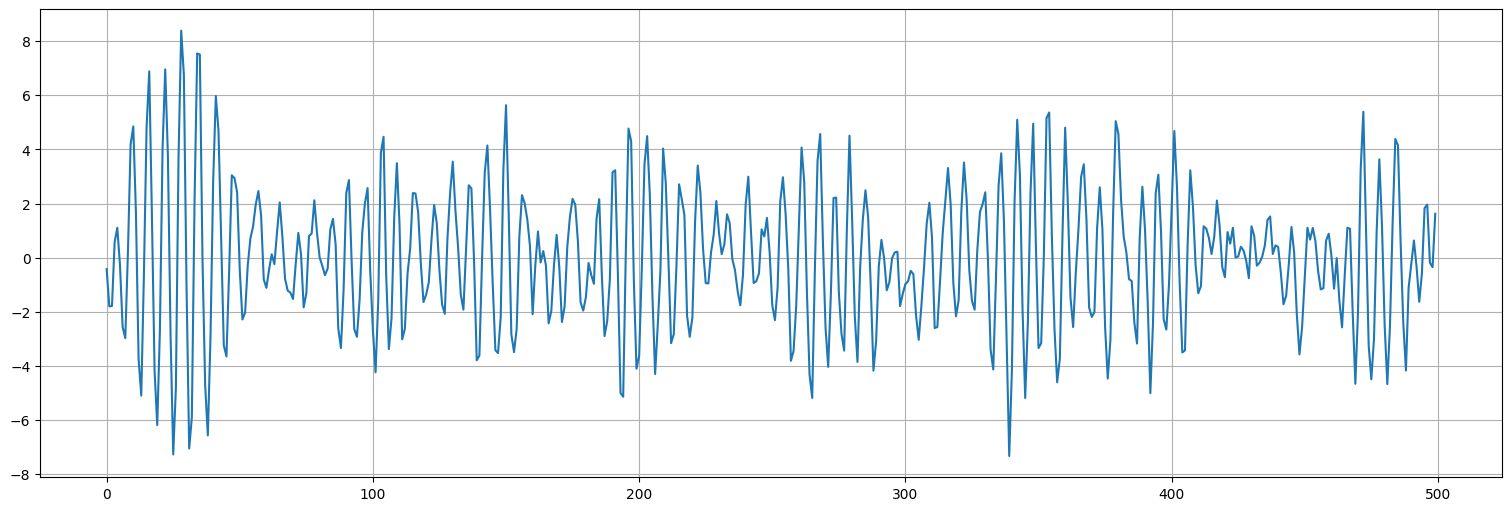

In [37]:
##Simulamos un AR(2) usando la función propia de python
x=arma_generate_sample([1,-1,.9],[1],n)
x=pd.Series(x)
x.plot();

Supongamos que sabemos exactamente los parámetros, en este caso media $\mu=0$, $\phi_1=1.0$ y $\phi_2=-0.9$.

 * Si solo predecimos por la media, el error MSE es el desvío estándar de la serie.
 * Si predecimos recursivamente $x_{t+1}$ por $\hat{x}_{t+1} = \phi_1 x_t + \phi_2 x_{t-1}$ entonces deberíamos poder reducir el error.

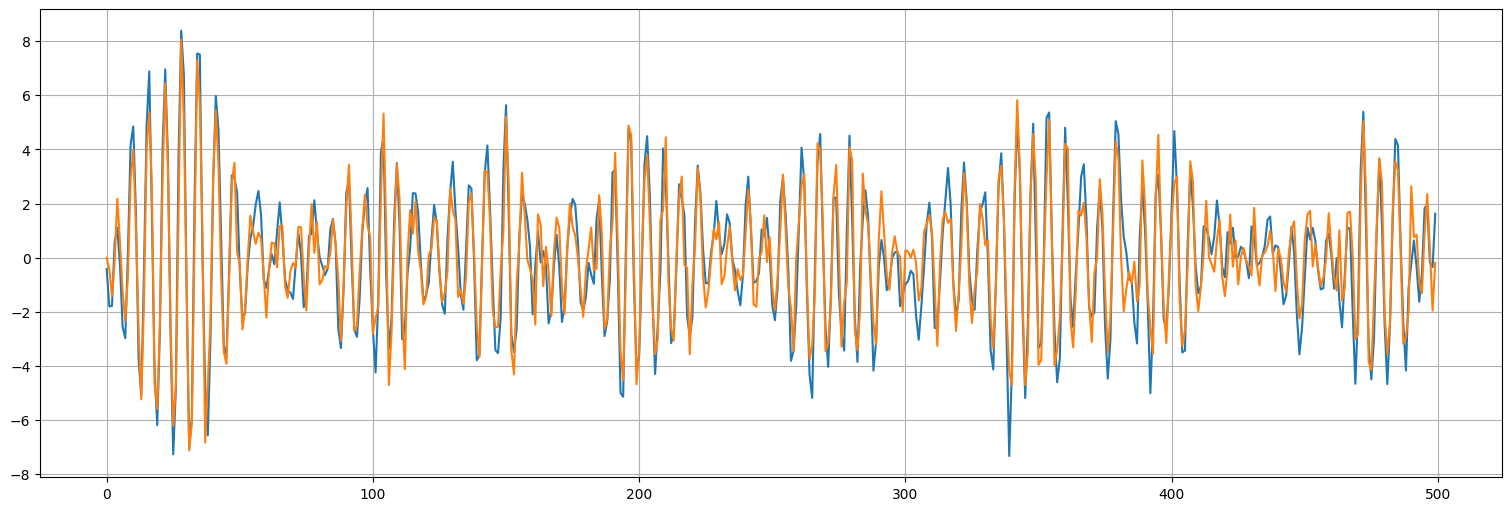

In [38]:
phi1 = 1.0
phi2 = -0.9

#aca va la predicción
x_hat = np.empty(n)

#los valores anteriores a t=0 los asumo 0 (la media)
x_hat[0] = phi1*0 + phi2*0
x_hat[1] = phi1 * x[0] + phi2*0

for i in range(2,n):
    x_hat[i] = phi1 * x[i-1] + phi2*x[i-2]

#lo convierto en una serie
x_hat = pd.Series(x_hat)

x.plot()
x_hat.plot();

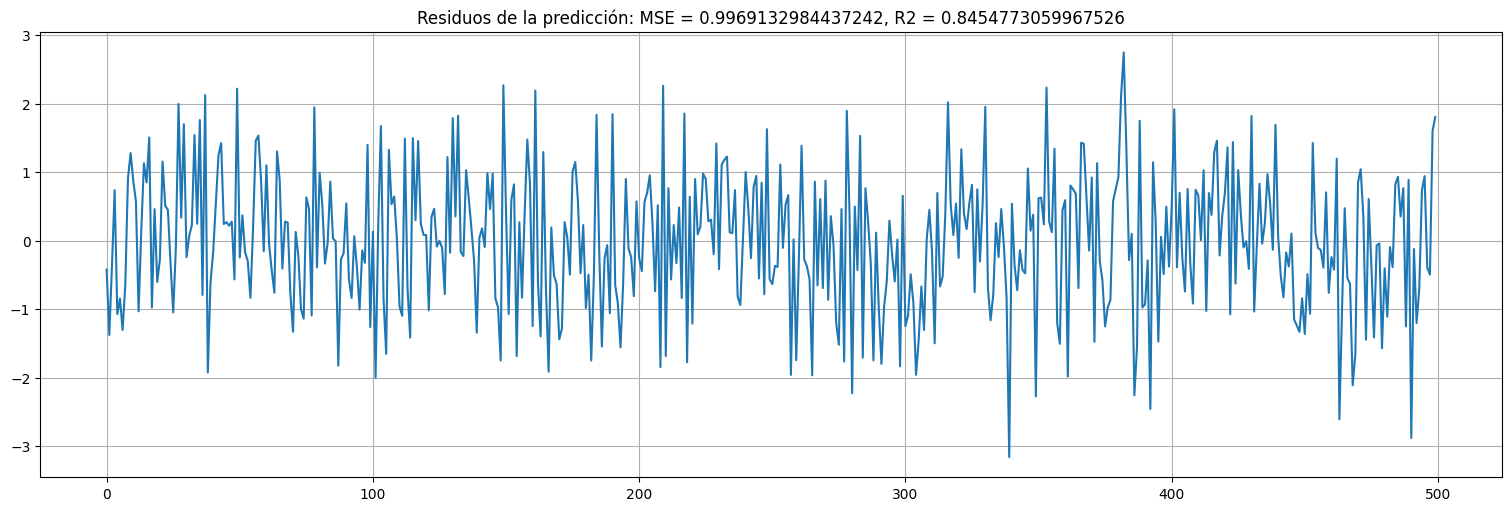

In [39]:
##Residuo
residuo = x-x_hat
MSE = np.var(residuo)
R2 = (np.var(x)-MSE)/np.var(x)
residuo.plot()
plt.title(f"Residuos de la predicción: MSE = {MSE}, R2 = {R2}");

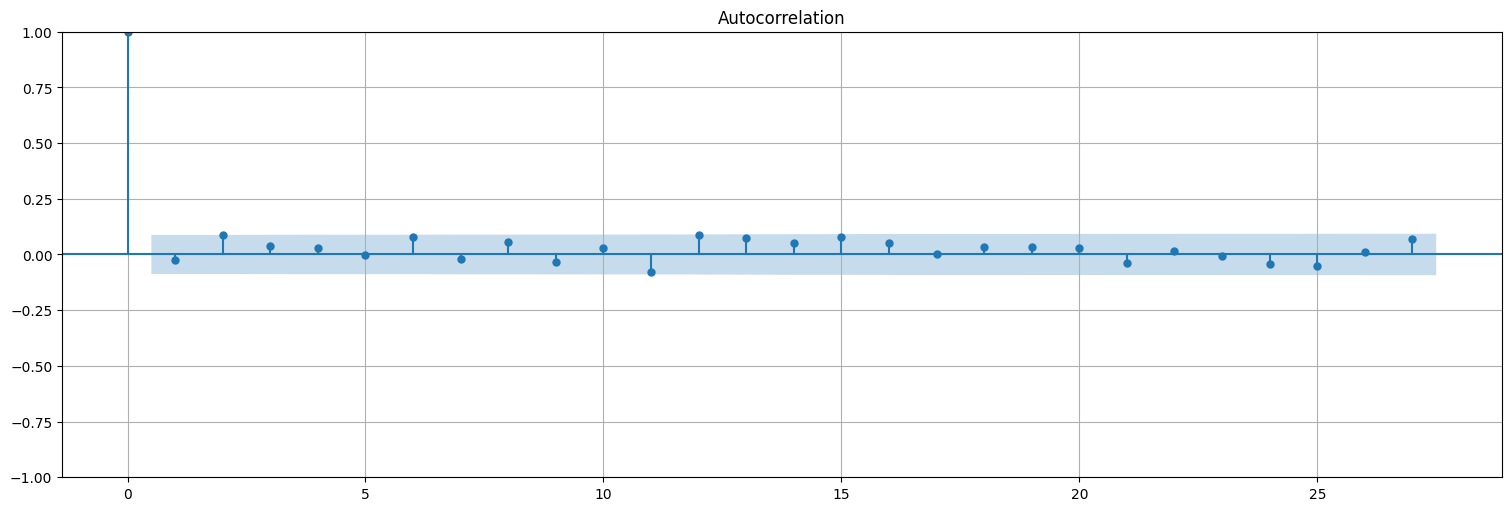

In [40]:
plot_acf(residuo);

## Ejercicios

### Estimación de la serie de precios de exportación del salmón noruego.


 1. Considere la serie `salmon` de precios de exportación de salmon noruego en dólares por kilogramo, incluida en la biblioteca `astsa` del curso.
 
    1. Analice la autocorrelación y autocorrelación parcial de la serie.
    2. Proponga un modelo autorregresivo de orden adecuado y ajuste el mismo. Analice los residuos obtenidos y el ajuste del modelo.

 
 2. Se propone ahora un segundo modelo de la forma:
$$x_t = \beta_0 + \beta_1 t + v_t$$
         
    con $v_t$ autorregresivo. Realice un ajuste por modelo lineal para estimar $\beta_0$ y $\beta_1$.
    
    
 3. Con los residuos del ajuste anterior ($v_t$), ajuste un modelo autorregresivo de orden adecuado y compare los resultados con el modelo de la primera parte.

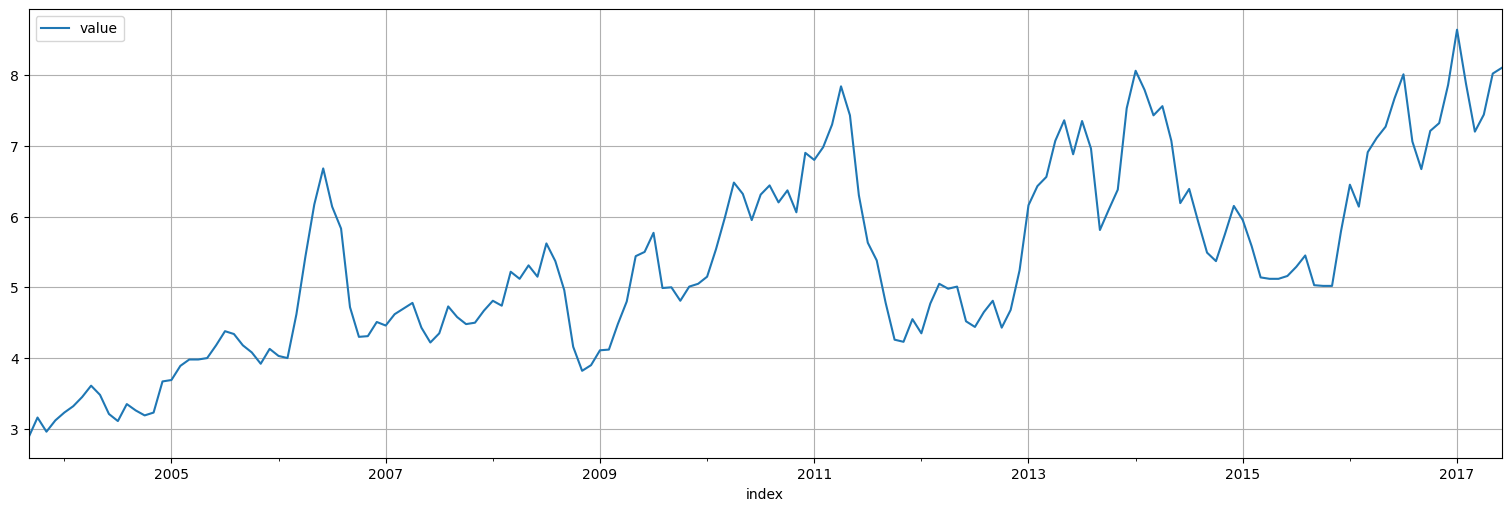

In [41]:
salmon = astsa.salmon
salmon.plot();